In [1]:
%load_ext autoreload
%autoreload 2

# Download utils

In [ ]:
# !wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
# !tar -xjf LJSpeech-1.1.tar.bz2
# !mv LJSpeech-1.1/ hw_tts/data/
# !mv LJSpeech-1.1.tar.bz2 hw_tts/data/

In [ ]:
# %pip3 install librosa
# %pip3 install googledrivedownloader
# %pip3 install torch==1.10.0+cu111 torchaudio==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# !git clone https://github.com/NVIDIA/waveglow.git
# !mv waveglow/ hw_tts/data/

# Data preprocessing

In [2]:
import torch
import torch.nn as nn
import torchaudio
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
from torch.utils.data import DataLoader
from hw_tts.datasets import LJSpeechDataset, collate_fn
from hw_tts.melspecs import MelSpectrogram, MelSpectrogramConfig

featurizer = MelSpectrogram(MelSpectrogramConfig())

DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dataloader = DataLoader(LJSpeechDataset('./hw_tts/data/'), batch_size=4, collate_fn=collate_fn)

test_batch = next(iter(dataloader))
test_batch["melspecs"] = featurizer(test_batch["waveforms"]).transpose(1, 2)

In [4]:
from hw_tts.aligners import GraphemeAligner

aligner = GraphemeAligner(melspec_sr=22050).to(DEVICE)

test_batch["durations"] = (aligner(
    test_batch["waveforms"].to(DEVICE), test_batch["waveforms_lengths"], test_batch["transcripts"]
) * test_batch["melspecs"].shape[-2]).long()

# Model

(torch.Size([4, 769, 80]), torch.Size([4, 833, 80]))

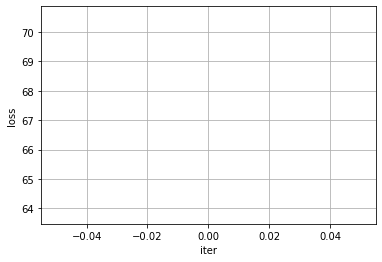

In [9]:
from hw_tts.models import FastSpeech

model = FastSpeech(
    d_model=384,
    n_head=2,
    n_tokens=51,
    n_encoders=6,
    n_decoders=6,
    hidden_size=1536,
    duration_hidden=256,
    alpha=1.,
    melspec_size=80,
    kernel_size=3
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
l2 = nn.MSELoss()
l1 = nn.L1Loss()

loss_values = []

n_iters = 1
for _ in range(n_iters):
    mels, durs = model(test_batch)
    max_mel_len = min(mels.shape[-2], test_batch["melspecs"].shape[-2])
    
    loss = l2(mels[:, :max_mel_len], test_batch["melspecs"][:, :max_mel_len]) + \
        l1(durs, test_batch["durations"].float())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    
    clear_output(wait=True)
    plt.plot(loss_values)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.grid()

In [6]:
from prettytable import PrettyTable


model = FastSpeech(
    d_model=384,
    n_head=2,
    n_tokens=51,
    n_encoders=6,
    n_decoders=6,
    hidden_size=1536,
    duration_hidden=256,
    alpha=1.,
    melspec_size=80,
    kernel_size=3
)

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)


+------------------------------------------------------------------------------+------------+
|                                   Modules                                    | Parameters |
+------------------------------------------------------------------------------+------------+
|                               embedding.weight                               |   19584    |
|                    encoder_layers.0.multihead.norm.weight                    |    384     |
|                     encoder_layers.0.multihead.norm.bias                     |    384     |
|           encoder_layers.0.multihead.initial_layers.query.0.weight           |   147456   |
|            encoder_layers.0.multihead.initial_layers.query.0.bias            |    384     |
|            encoder_layers.0.multihead.initial_layers.key.0.weight            |   147456   |
|             encoder_layers.0.multihead.initial_layers.key.0.bias             |    384     |
|           encoder_layers.0.multihead.initial_layers.value.

55579089